<a href="https://colab.research.google.com/github/haaden/MSDS_422-Machine-Learning/blob/main/MSDS422_Assignment_08_20201018_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

DATE: October 18, 2020

#### MSDS422 Assignment 08:

Binary classification of movie reviews as positive or negative using the text of the review.
Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>


In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.24-cp36-none-any.whl size=6506 sha256=79e6ed2b6da2ba8f3099014c990cbdbb0dec4a8b853d24e5f3befadb7135dd01
  Stored in directory: /root/.cache/pip/wheels/a9/1a/d2/1264c7b2ededd8fab16491e873fb037693d6f8c93f96b72ffa
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.21-cp36-none-any.whl size=6975 sha256=3e0bdac56b298b86c581bb182644e9e122f7fb0309214541e1a935297c91d942
  Stored in directory: /root/.cache/pip/wheels/97/df/a7/a7ffb423fcdfabbffa6e7d36eee044a9f904f8d0ed246eaf84
  Created wheel for compress-json: filename=compress_json-1.0.4-cp36-none-any.whl size=4586 sha256=7301c8749e0af82176a1b1d18c46138f50f89c9c632e01c5f684e4306b252d4c
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix as pcm
from sklearn.metrics import confusion_matrix

In [ ]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow_datasets as tfds
from plot_keras_history import plot_history

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

### Download and Load IMDB dataset
<div class="alert alert-block alert-success">
This text classification tutorial trains a <b>RNN - Recurrent Neural Network</b><br><br>
https://developers.google.com/machine-learning/glossary/#recurrent_neural_network <br><br> <b>IMDB large movie review dataset</b><br>
http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis</div>

In [ ]:
#train_dataset, validate_dataset, test_dataset= tfds.load(name='imdb_reviews/subwords8k',  split=('train[:60%]', 'train[60%:]', 'test'),  as_supervised=True)

In [ ]:
dataset['train']

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'],  dataset['test']

  <div class="alert alert-block alert-info"> 
 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`)</div>

In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


#### This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [ ]:
sample_string = 'Hello Northwestern Data Science Students.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 4277, 4413, 878, 1848, 2675, 2975, 2509, 6623, 8044, 7975]
The original string: "Hello Northwestern Data Science Students."


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
4277 ----> North
4413 ----> western 
878 ----> Da
1848 ----> ta 
2675 ----> Sci
2975 ----> ence 
2509 ----> Stu
6623 ----> dent
8044 ----> s
7975 ----> .


In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

### IMDB Reviews  - Label and Plain Text Review

0  0 (neg) 	This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.<br><br>

1  0 (neg) 	I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.<br><br>

2  0 (neg) 	Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.<br><br>

3  1 (pos) 	This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.<br><br>

4  1 (pos)  As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.<br><br>

### IMDB Reviews  - Label and Encoded Review 

<div class="alert alert-block alert-info"> 
<b>imdb_reviews</b><br>
https://www.tensorflow.org/datasets/catalog/imdb_reviews<br><br>
    FeaturesDict({<br>
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),<br>
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),<br>
}) 
    
</div>

0   0 (neg) 	array([ 62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975])<br><br>

1 	0 (neg) 	array([ 12, 31, 93, 867, 7, 1256, 6585, 7961, 421, 365, 2, 26, 14, 9, 988, 1089, 7, 4, 6728, 6, 276, 5760, 2587, 2, 81, 6118, 8029, 2, 139, 1892, 7961, 5, 5402, 246, 25, 1, 1771, 350, 5, 369, 56, 5397, 102, 4, 2547, 3, 4001, 25, 14, 7822, 209, 12, 3531, 6585, 7961, 99, 1, 32, 18, 4762, 3, 19, 184, 3223, 18, 5855, 1045, 3, 4232, 3337, 64, 1347, 5, 1190, 3, 4459, 8, 614, 7, 3129, 2, 26, 22, 84, 7020, 6, 71, 18, 4924, 1160, 161, 50, 2265, 3, 12, 3983, 2, 12, 264, 31, 2545, 261, 6, 1, 66, 2, 26, 131, 393, 1, 5846, 6, 15, 5, 473, 56, 614, 7, 1470, 6, 116, 285, 4755, 2088, 7961, 273, 119, 213, 3414, 7961, 23, 332, 1019, 3, 12, 7667, 505, 14, 32, 44, 208, 7975])<br><br>

2 	0 (neg) 	array([ 636, 102, 4714, 8, 1, 4333, 4, 4135, 47, 1325, 1174, 1139, 8, 11, 4, 2402, 1878, 2, 5, 5619, 4513, 5, 6872, 5063, 2290, 7961, 257, 1779, 695, 20, 53, 278, 382, 7, 374, 221, 10, 16, 10, 17, 128, 288, 25, 2259, 95, 4, 1325, 1174, 542, 1923, 1, 121, 6, 5217, 412, 6696, 2, 5496, 1459, 102, 7, 1120, 2098, 1272, 4, 957, 767, 8037, 28, 7042, 4, 957, 767, 8037, 1705, 5, 7, 413, 3439, 1, 5758, 2522, 2, 144, 2574, 7605, 8, 2339, 3212, 34, 15, 61, 25, 1, 6285, 7961, 23, 3224, 6, 1, 1818, 4442, 10, 16, 10, 17, 3281, 78, 7880, 3299, 6659, 34, 13, 1314, 25, 1, 7177, 748, 6, 1, 6135, 7961, 421, 1, 4255, 136, 2133, 735, 3093, 7961, 4564, 3, 745, 3, 636, 102, 5, 3981, 1780, 7, 31, 4086, 102, 5217, 412, 5244, 23, 4410, 2264, 2, 1, 7177, 4277, 7961, 23, 1, 405, 5287, 7961, 3543, 8045, 24, 10, 16, 10, 17, 7177, 1942, 35, 5202, 40, 23, 4, 3021, 3182, 7961, 1340, 432, 831, 6, 1779, 2932, 157, 22, 14, 6973, 7961, 396, 2, 317, 2, 7, 3977, 49, 155, 716, 11, 4326, 447, 7975])<br><br>

3 	1 (pos) 	array([ 62, 9, 1, 312, 6, 32, 23, 4, 7809, 47, 7513, 7961, 1309, 6971, 7961, 72, 1, 470, 6, 1, 386, 83, 186, 5082, 22, 116, 285, 2924, 20, 37, 7117, 228, 94, 4, 301, 1579, 7974, 5403, 7961, 5, 2211, 654, 23, 4, 533, 6, 4916, 3, 6223, 455, 695, 48, 805, 127, 5, 7627, 20, 5111, 28, 20, 5995, 58, 5766, 64, 4682, 1, 184, 3740, 3, 173, 29, 84, 5302, 1031, 7, 4038, 2, 84, 6338, 3419, 8044, 2, 56, 4, 1892, 7961, 5, 5270, 7961, 913, 5340, 7961, 192, 698, 1951, 219, 44, 116, 883, 3, 133, 381, 32, 11, 242, 471, 5, 45, 13, 2064, 1, 4642, 7961, 15, 5809, 8029, 7975])<br><br>

4 	1 (pos) 	array([ 249, 929, 31, 2699, 104, 2, 51, 1, 707, 13, 186, 7141, 7961, 11, 14, 32, 29, 1115, 604, 2766, 3816, 449, 3, 19, 184, 67, 864, 410, 1, 6257, 4050, 203, 47, 6, 1, 1110, 763, 3665, 8040, 3, 324, 571, 29, 268, 53, 239, 7, 35, 4402, 104, 2, 26, 72, 484, 38, 1039, 54, 29, 1790, 2, 53, 544, 1, 4402, 478, 6, 4, 4114, 7961, 570, 212, 1158, 3, 134, 1, 771, 611, 4, 172, 81, 2310, 28, 103, 180, 51, 35, 55, 7886, 44, 14, 595, 5904, 183, 144, 265, 76, 1, 7845, 49, 7, 4402, 49, 30, 461, 583, 7975])<br><br>

## Preprocess Data for Training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
#validate_dataset=train_dataset.shuffle(BUFFER_SIZE)
#validate_dataset=train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

<div class="alert alert-block alert-success">
Build a `tf.keras.Sequential` model and start with an embedding layer.  An embedding layer stores one vector per word. Next, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.<br>

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer<br>

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next<br>

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies</div>

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

#### Bidirectional RNNs
<br>
For sequences other than time series (e.g. text), it is often the case that a RNN model can perform better if it not only processes sequence from start to end, but also backwards. For example, to predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it.
<br><br>
Keras provides an easy API for you to build such bidirectional RNNs: the keras.layers.Bidirectional wrapper.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.SimpleRNN</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN
    </div>

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 548,673
Trainable params: 548,673
Non-trainable params: 0
_________________________________________________________________


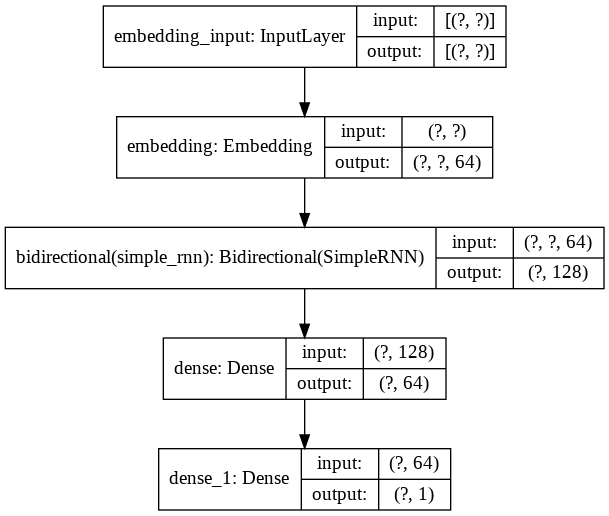

In [ ]:
keras.utils.plot_model(model, "BinaryClassificationModel.png", show_shapes=True) 

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>    

## Compile Model 

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 300s 766ms/step - loss: 0.6925 - accuracy: 0.5156 - val_loss: 0.6871 - val_accuracy: 0.5474
Epoch 2/10
391/391 [==============================] - 304s 777ms/step - loss: 0.5883 - accuracy: 0.7044 - val_loss: 0.4453 - val_accuracy: 0.8135
Epoch 3/10
391/391 [==============================] - 298s 762ms/step - loss: 0.3498 - accuracy: 0.8579 - val_loss: 0.3562 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 308s 789ms/step - loss: 0.2641 - accuracy: 0.9021 - val_loss: 0.3537 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 305s 779ms/step - loss: 0.2091 - accuracy: 0.9241 - val_loss: 0.3694 - val_accuracy: 0.8344
Epoch 6/10
391/391 [==============================] - 303s 774ms/step - loss: 0.1718 - accuracy: 0.9420 - val_loss: 0.4061 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 301s 769ms/step - loss: 0.1358 - accuracy: 0.9556 - val_loss: 0.4395 -

## Test the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 63s 160ms/step - loss: 0.4870 - accuracy: 0.8363
Test Loss: 0.4870084226131439
Test Accuracy: 0.8362799882888794


In [ ]:
train_loss, train_acc = model.evaluate(train_dataset)

print('Test Loss: {}'.format(train_loss))
print('Test Accuracy: {}'.format(train_acc))

391/391 [==============================] - 64s 163ms/step - loss: 0.0489 - accuracy: 0.9916
Test Loss: 0.048947352916002274
Test Accuracy: 0.9915599822998047


<div class="alert alert-block alert-info"> 
The above model does not mask the padding applied to the sequences.<br> This can lead to skew if trained on padded sequences and test on un-padded sequences<br>
<b>If the prediction is >= 0.5, it is positive else it is negative</b></div>

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad, model):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

#### Prediction 1 RNN Model on a sample text without padding

In [ ]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text,model = model, pad=False)
print(predictions)

[[0.1433214]]


#### Prediction 2 RNN Model on a sample text with padding

In [ ]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True, model = model)
print(predictions)

[[0.1433214]]


In [ ]:
model.predict(encoder.decode('This movies was good'))

TypeError: ignored

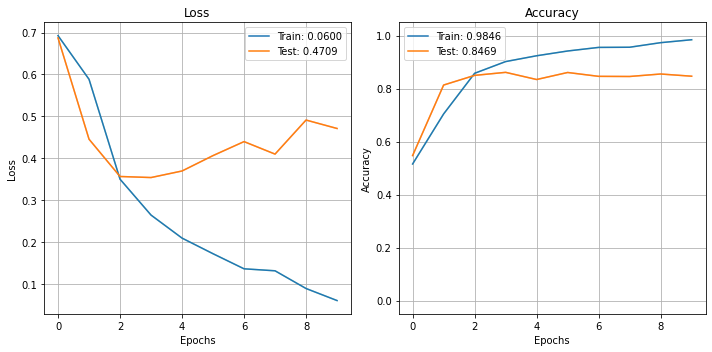

In [ ]:
plot_history(history.history)
plt.show()

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

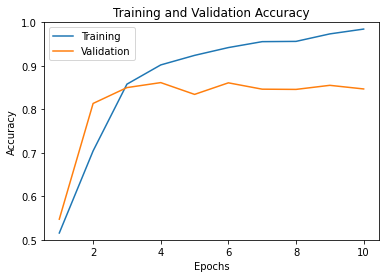

In [ ]:
plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

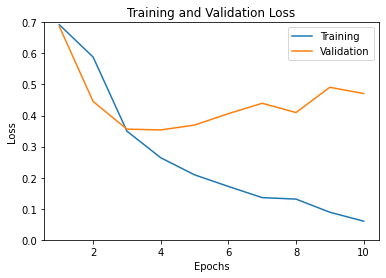

In [ ]:
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.7])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
## on train data
df_train1.head()

,label,text
0,0,"[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 3..."
1,0,"[12, 31, 93, 867, 7, 1256, 6585, 7961, 421, 36..."
2,0,"[636, 102, 4714, 8, 1, 4333, 4, 4135, 47, 1325..."
3,1,"[62, 9, 1, 312, 6, 32, 23, 4, 7809, 47, 7513, ..."
4,1,"[249, 929, 31, 2699, 104, 2, 51, 1, 707, 13, 1..."


In [ ]:
df_train1 = tfds.as_dataframe(dataset['train'], info)

In [ ]:
train_dataset

<PaddedBatchDataset shapes: ((None, None, None, None), (None, None, None)), types: (tf.int64, tf.int64)>

In [ ]:
test_train = model.predict(train_dataset)

In [ ]:
test_pre_trian = np.where(test_train>0.5, 1,0)

In [ ]:
y_train= np.array(df_train1['label'])

In [ ]:
cm_train = confusion_matrix(test_pre_trian, y_train)

In [ ]:
cm_train

array([[12429,   140],
       [   71, 12360]])

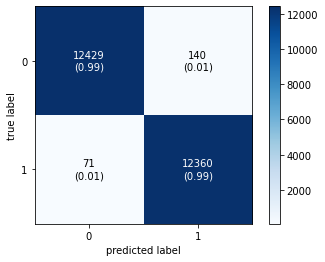

In [ ]:
fig, ax = pcm(conf_mat=cm_train, 
                               show_absolute=True,
                                show_normed=True,
                                colorbar=True,
              
                                )
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_pre_trian, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12569
           1       0.99      0.99      0.99     12431

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



In [ ]:
## on test data


In [ ]:
df_test1 = tfds.as_dataframe(dataset['test'], info)

In [ ]:
ar =np.array(df_test1.text)

In [ ]:
test_test = model.predict(test_dataset)

In [ ]:
test_pre_test = np.where(test_test>0.5, 1,0)

In [ ]:
y_test= np.array(df_test1['label'])

In [ ]:
cm = confusion_matrix(test_pre_test, y_test)

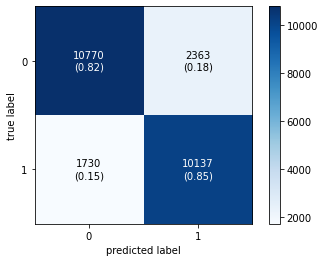

In [ ]:
fig, ax = pcm(conf_mat=cm, 
                               show_absolute=True,
                                show_normed=True,
                                colorbar=True,
              
                                )
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_pre_test, y_test))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     13133
           1       0.81      0.85      0.83     11867

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64, mask_zero= True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.),
              metrics=['accuracy'] )

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

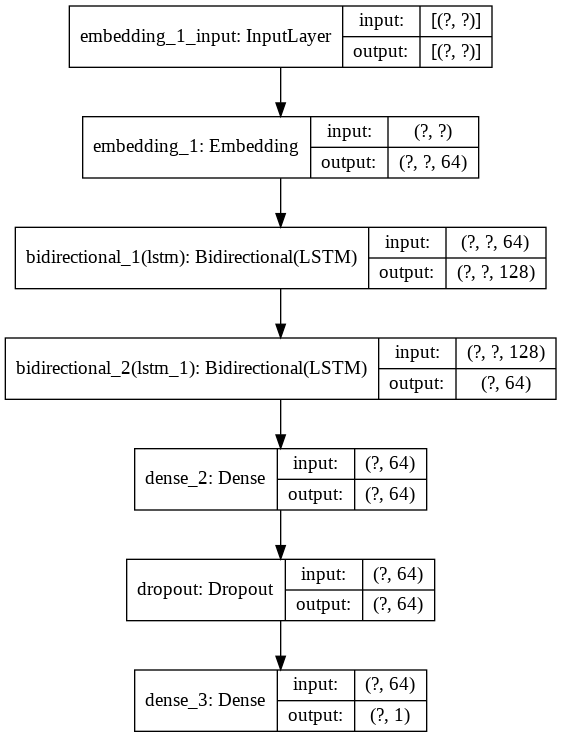

In [ ]:
keras.utils.plot_model(model2, "LSTMBinaryClassificationModel.png", show_shapes=True) 

In [ ]:
history2 = model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1276s 3s/step - loss: 0.6202 - accuracy: 0.6364 - val_loss: 0.4290 - val_accuracy: 0.8115
Epoch 2/10
391/391 [==============================] - 1297s 3s/step - loss: 0.3344 - accuracy: 0.8700 - val_loss: 0.3169 - val_accuracy: 0.8734
Epoch 3/10
391/391 [==============================] - 1274s 3s/step - loss: 0.2408 - accuracy: 0.9137 - val_loss: 0.2987 - val_accuracy: 0.8750
Epoch 4/10
391/391 [==============================] - 1294s 3s/step - loss: 0.1935 - accuracy: 0.9348 - val_loss: 0.3047 - val_accuracy: 0.8755
Epoch 5/10
391/391 [==============================] - 1301s 3s/step - loss: 0.1594 - accuracy: 0.9492 - val_loss: 0.3648 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 1288s 3s/step - loss: 0.1350 - accuracy: 0.9581 - val_loss: 0.3788 - val_accuracy: 0.8703
Epoch 7/10
391/391 [==============================] - 1278s 3s/step - loss: 0.1148 - accuracy: 0.9672 - val_loss: 0.4214 - val_accuracy:

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)
print('Test Accuracy: {}'.format(test_acc))
print('Test Loss: {}'.format(test_loss))

391/391 [==============================] - 248s 635ms/step - loss: 0.5509 - accuracy: 0.8572
Test Accuracy: 0.857200026512146
Test Loss: 0.5508971214294434


In [ ]:
train_loss, train_acc = model2.evaluate(train_dataset)
print('Test Accuracy: {}'.format(test_acc))
print('Test Loss: {}'.format(train_loss))

391/391 [==============================] - 245s 626ms/step - loss: 0.0486 - accuracy: 0.9889
Test Accuracy: 0.857200026512146
Test Loss: 0.04858934506773949


#### Prediction 1 LSTM Model on a sample text without padding

In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.00447091]]


#### Prediction 2 LSTM Model on a sample text with padding

In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.00404996]]


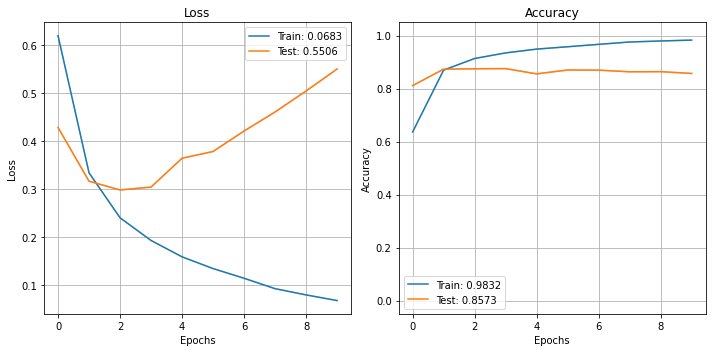

In [ ]:
plot_history(history2.history)
plt.show()

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training)

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

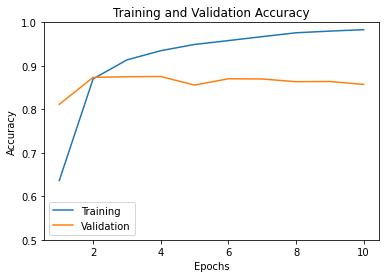

In [ ]:
plt.plot(range(1, len(acc) + 1), history2.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history2.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

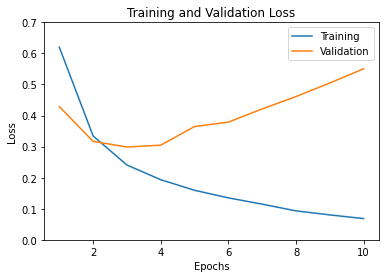

In [ ]:
plt.plot(range(1, len(loss) + 1), history2.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history2.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.7])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model2.predict(test_dataset)

array([[-3.088159 ],
       [ 3.2782266],
       [-3.2392519],
       ...,
       [-4.3971915],
       [ 2.7856274],
       [ 2.1251824]], dtype=float32)

In [ ]:
tt= dataset['train']

In [ ]:
dataset['train']

TypeError: ignored

In [ ]:
next(iter(tt))

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
 array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
        5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
           3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
          79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
          33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
          27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
          19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
         102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
           3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
           2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
         102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
          27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
          12,  258, 2306,   13,   91,   29,  171,   52,  229,    

In [ ]:
encoder.decode([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
        5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
           3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
          79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
          33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
          27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
          19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
         102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
           3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
           2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
         102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
          27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
          12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
        5790,  995, 7968,    8,   52, 2948, 5240, 8039, 7968,    8,   74,
        1249,    3,   12,  117, 2438, 1369,  192,   39, 7975])

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [ ]:
nn = tfds.as_dataframe(train_dataset, info)

In [ ]:
test = model2.predict(dataset['train'].take(10))

NameError: ignored

In [ ]:
df_2test = tfds.as_dataframe(dataset['test'], info)

In [ ]:
pre_test_2 = model2.predict(test_dataset)

In [ ]:
pre_test_2 = np.where(pre_test_2>0.5, 1,0)

In [ ]:
y_test2 = np.array(df_2test['label'])

In [ ]:
cm_test2 = confusion_matrix(pre_test_2, y_test2)

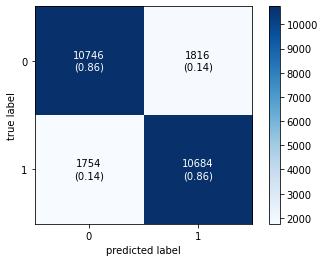

In [ ]:
fig, ax = pcm(conf_mat=cm_test2, 
                               show_absolute=True,
                                show_normed=True,
                                colorbar=True,
              
                                )
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(pre_test_2, y_test2))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12562
           1       0.85      0.86      0.86     12438

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [ ]:
# train

In [ ]:
df_2train = tfds.as_dataframe(dataset['train'], info)

In [ ]:
pre_train_2 = model2.predict(train_dataset)

In [ ]:
pre_train_2 = np.where(pre_train_2>0.5, 1,0)

In [ ]:
y_train2 = np.array(df_2train['label'])

In [ ]:
cm_train2 = confusion_matrix(pre_train_2, y_train2)

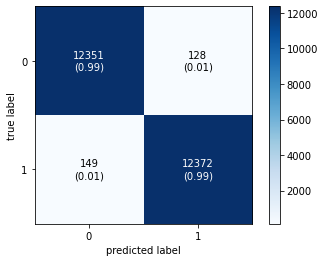

In [ ]:
fig, ax = pcm(conf_mat=cm_train2, 
                               show_absolute=True,
                                show_normed=True,
                                colorbar=True,
              
                                )
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(pre_train_2, y_train2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12479
           1       0.99      0.99      0.99     12521

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



In [ ]:
model_comp= pd.DataFrame({'Bidirectional layer': [1,2],
              'Number of dense layer': [1,1],
              
              'Training Accuracy' :[99.16,98.89],
              'Test Accuracy': [83.63, 85.72]
    

})
model_comp.index= ['Model 1 RNN','Model 2 LSTM']

model_comp

,Bidirectional layer,Number of dense layer,Training Accuracy,Test Accuracy
Model 1 RNN,1,1,99.16,83.63
Model 2 LSTM,2,1,98.89,85.72


In [ ]:
df_2test.head()

,label,text
0,1,"[173, 29, 185, 13, 115, 1956, 8044, 3, 398, 12..."
1,1,"[133, 2237, 64, 1229, 1795, 6, 4, 615, 7974, 1..."
2,0,"[3567, 47, 3634, 7978, 7974, 7981, 2, 7998, 58..."
3,0,"[7128, 127, 2196, 2185, 1098, 1040, 687, 1145,..."
4,1,"[249, 4, 2256, 3293, 453, 3483, 7961, 5014, 12..."
